In [1]:
import os
import dotenv
import sys
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

project_dir = os.path.dirname(os.path.abspath(''))  # might be __file__
print(project_dir)
sys.path.insert(0, project_dir)

from src.utils.utilities import nzvKJ
from src.features.custom_transformers import ColumnExtractor, DFRobustScaler, DFFeatureUnion, DFImputer
from src.features.custom_transformers import DummyTransformer, Log1pTransformer, ZeroFillTransformer
from src.features.custom_transformers import DateFormatter, DateDiffer, MultiEncoder

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn import svm
from sklearn.mixture import GaussianMixture as GMM

emotion_codes = {
    'W': 'Ärger (Wut)',
    'L': 'Langeweile',
    'E': 'Ekel',
    'A': 'Angst',
    'F': 'Freude',
    'T': 'Trauer',
    'N': 'Neutral'
}



#project_dir = os.path.join(os.path.dirname(__file__), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

feature_file = os.path.join(project_dir, "data/processed/features.csv")
filename_file = os.path.join(project_dir, "data/processed/filenames.csv")
print(feature_file)
df = pd.read_csv(feature_file, sep=';')
filenames = pd.read_csv(filename_file, sep=';')

y = pd.DataFrame(filenames['filename'].apply(lambda x : x[5]))
y.columns = ['label']

speaker = pd.DataFrame(filenames['filename'].apply(lambda x : x[0:2]))
speaker.columns = ['speaker']

/media/win-d/myfiles/2019/emodb-classifier
/media/win-d/myfiles/2019/emodb-classifier/data/processed/features.csv


In [2]:
print(df.shape)
display(df.head())
wav_path =  os.path.join(project_dir, "data/raw/wav")
wav_files = os.listdir(wav_path)
print('df shape / y shape / N Wav files {}/{}/{}'.format(df.shape[0], y.shape[0], len(wav_files)))

(535, 6375)


,name,frameTime,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,'unknown',0.0,2.935072,0.203297,0.010989,0.295957,0.521095,1.027880,0.225138,0.506785,...,4.534243,0.369439,2.608828,2.575876,79.16969,0.681891,117.0939,56.66211,120.51720,53.83758
1,'unknown',0.0,3.087914,0.155844,0.889610,0.230797,0.747831,1.160158,0.517033,0.412327,...,5.695182,0.373871,3.123539,3.173356,-62.70013,0.684225,126.9756,63.87025,157.94470,60.62523
2,'unknown',0.0,3.673083,0.677778,0.011111,0.379012,0.901301,1.801537,0.522289,0.900236,...,8.072541,0.486622,3.802572,3.807790,-728.79330,0.385978,177.8207,89.42555,153.75670,92.12224
3,'unknown',0.0,3.149658,0.549223,0.720207,0.252871,0.691515,1.456156,0.438644,0.764641,...,8.049535,0.537332,3.237765,3.310604,-44.45128,0.442254,161.9317,82.12952,134.20900,73.30933
4,'unknown',0.0,2.437313,0.632353,0.691177,0.386230,0.809192,1.433426,0.422963,0.624234,...,6.743886,0.511177,2.217382,2.281039,-34.83302,0.492747,106.7201,57.31511,97.52015,41.16851


df shape / y shape / N Wav files 535/535/535


## Basic Feature Selection

Only Kuhn Johnson nonzero variabce implemented


TODO: Improve
http://scikit-learn.org/stable/modules/feature_selection.html



In [3]:
dropvars = ['filename', 'name', 'frameTime']
nearZeroVar =  nzvKJ(df, df.columns)
# nearZeroVar =  nzvKJ(X_train,X_train.columns,freqCut = 20.)
varlist2drop = nearZeroVar[nearZeroVar['nzv']].index.tolist()

In [4]:
vars2remove = list(set(varlist2drop + dropvars))
vars2remove

['logHNR_sma_percentile1.0',
 'filename',
 'name',
 'logHNR_sma_minPos',
 'frameTime',
 'pcm_fftMag_spectralRollOff25.0_sma_percentile1.0']

In [5]:
NUM_FEATS = list(df.select_dtypes(include=['float64', 'int64']).columns)
NUM_FEATS = [x for x in NUM_FEATS if x not in vars2remove]
CAT_FEATS = list(df.select_dtypes(include=['object']).columns)
CAT_FEATS = [x for x in CAT_FEATS if x not in vars2remove]
CAT_FEATS

[]

## Explore Target Variable



In [6]:
y['label'].value_counts()

W    127
L     81
N     79
F     71
A     69
T     62
E     46
Name: label, dtype: int64

## Data Split / Pipeline / Target Transform / Resampling

### Split dataset into Train Test by - Speaker Assignment

In [7]:
random_state = 42
train_size = 2./3
speaker_values = list(np.unique(speaker.values))
n_speakers = len(speaker_values)
train, test = train_test_split(speaker_values, random_state=random_state, train_size=train_size)
print('There should be approx 2/3 of the speakers in train: {}'.format(len(train) / n_speakers))
train, test
train_filter = speaker['speaker'].apply(lambda x: x in train) 
test_filter = speaker['speaker'].apply(lambda x: x in test) 
print(speaker.shape[0])
pd.crosstab(train_filter, test_filter)

There should be approx 2/3 of the speakers in train: 0.6
535


speaker,False,True
speaker,,
False,337,0
True,0,198


In [8]:
df_train = df[train_filter]
df_test = df[test_filter]
y_train = y[train_filter]
y_test = y[test_filter]
print(df_train.shape[0], df_test.shape[0], y_train.shape[0], y_test.shape[0])

337 198 337 198


### Feature Pipeline and Target Transform 

In [9]:
# Preprocessing with a Pipeline that uses Pandas Capable Processors
pipeline = Pipeline([
    ('features', DFFeatureUnion([
        ('categoricals', Pipeline([
            ('extract', ColumnExtractor(CAT_FEATS)),
            ('dummy', DummyTransformer())
        ])),
        ('numerics', Pipeline([
            ('extract', ColumnExtractor(NUM_FEATS)),
            ('zero_fill', ZeroFillTransformer())
        ]))
    ])),
    ('scale', DFRobustScaler())
])
pipeline.fit(df_train)

Pipeline(memory=None,
         steps=[('features',
                 <src.features.custom_transformers.DFFeatureUnion object at 0x7f59e2413828>),
                ('scale',
                 <src.features.custom_transformers.DFRobustScaler object at 0x7f59e2413978>)],
         verbose=False)

In [10]:
X_train_t = pipeline.transform(df_train)
X_test_t = pipeline.transform(df_test)

In [11]:
lb = preprocessing.LabelBinarizer()
label_encoder = LabelEncoder()
y_train_t = label_encoder.fit_transform(y_train.values)
y_test_enc = label_encoder.fit_transform(y_test)
print(pd.Series(y_train_t).value_counts())
label_encoder.classes_

6    76
3    52
2    45
0    45
4    43
5    38
1    38
dtype: int64


/home/christian/.venvs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['A', 'E', 'F', 'L', 'N', 'T', 'W'], dtype=object)

### Resampling Training Data

In [12]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
#X, y = make_classification(n_classes=2, class_sep=2,
#... weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
#... n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
#>>> print('Original dataset shape %s' % Counter(y))
#Original dataset shape Counter({1: 900, 0: 100})
sm = SMOTE(random_state=42)
X_train_t_res, y_train_t_res = sm.fit_resample(X_train_t, y_train_t)
print('Resampled dataset shape %s' % Counter(y_train_t_res))
# Resampled dataset shape Counter({0: 900, 1: 900})
print("resampled shape", X_train_t_res.shape)
print("original shape", X_train_t.shape)
# 637 / 91 gives number of emotions

Using TensorFlow backend.
/home/christian/.venvs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/christian/.venvs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/christian/.venvs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/christian/.venvs/py36/lib/python3.6

Resampled dataset shape Counter({1: 76, 2: 76, 4: 76, 6: 76, 3: 76, 5: 76, 0: 76})
resampled shape (532, 6370)
original shape (337, 6370)


# Fit Models

https://elitedatascience.com/imbalanced-classes

## GMM

In [13]:
n_classes = len(np.unique(y_train))
# covariance_type=covar_type ['spherical', 'diag', 'tied', 'full']
# 
# Try GMMs using different types of covariances.
#classifiers = dict((covar_type, GMM(n_components=n_classes,
#                    covariance_type=covar_type, init_params='wc', n_iter=20))
#                   for covar_type in ['spherical', 'diag', 'tied', 'full'])


gmm_clf = GMM(n_components=n_classes, covariance_type='spherical' )
gmm_clf.fit(X_train_t_res, y_train_t_res) 


# GMM?

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [14]:
y_pred = gmm_clf.predict(X_test_t) 
#classification_report(y_test_enc, y_pred, output_dict=True)
print(classification_report(y_test_enc, y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       0.15      0.79      0.25        24
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        26
           3       0.13      0.21      0.16        29
           4       0.22      0.14      0.17        36
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        51

    accuracy                           0.15       198
   macro avg       0.07      0.16      0.08       198
weighted avg       0.08      0.15      0.08       198



/home/christian/.venvs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SVM

In [15]:
svm_clf = svm.LinearSVC()
svm_clf.fit(X_train_t_res, y_train_t_res) 
# Alternative:  class_weight='balanced',

/home/christian/.venvs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [16]:
X_test_t = pipeline.transform(df_test)
y_pred = svm_clf.predict(X_test_t) 


print(classification_report(y_test_enc, y_pred))
classification_report(y_test_enc, y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.50      0.33      0.40        24
           1       0.33      0.62      0.43         8
           2       0.35      0.31      0.33        26
           3       0.81      0.59      0.68        29
           4       0.44      0.44      0.44        36
           5       0.45      0.54      0.49        24
           6       0.78      0.88      0.83        51

    accuracy                           0.57       198
   macro avg       0.52      0.53      0.51       198
weighted avg       0.57      0.57      0.56       198



{'0': {'precision': 0.5,
  'recall': 0.3333333333333333,
  'f1-score': 0.4,
  'support': 24},
 '1': {'precision': 0.3333333333333333,
  'recall': 0.625,
  'f1-score': 0.43478260869565216,
  'support': 8},
 '2': {'precision': 0.34782608695652173,
  'recall': 0.3076923076923077,
  'f1-score': 0.32653061224489793,
  'support': 26},
 '3': {'precision': 0.8095238095238095,
  'recall': 0.5862068965517241,
  'f1-score': 0.68,
  'support': 29},
 '4': {'precision': 0.4444444444444444,
  'recall': 0.4444444444444444,
  'f1-score': 0.4444444444444444,
  'support': 36},
 '5': {'precision': 0.4482758620689655,
  'recall': 0.5416666666666666,
  'f1-score': 0.49056603773584906,
  'support': 24},
 '6': {'precision': 0.7758620689655172,
  'recall': 0.8823529411764706,
  'f1-score': 0.8256880733944953,
  'support': 51},
 'accuracy': 0.5656565656565656,
 'macro avg': {'precision': 0.5227522293275132,
  'recall': 0.531528084266421,
  'f1-score': 0.5145731109307626,
  'support': 198},
 'weighted avg': {'pr

In [17]:
classification_report?

## Generate Report

In [18]:
np.set_printoptions(precision=2)

In [19]:
display(confusion_matrix(y_test_enc, y_pred))
label_encoder.classes_

array([[ 8,  3,  6,  0,  3,  1,  3],
       [ 1,  5,  0,  0,  1,  0,  1],
       [ 2,  2,  8,  0,  5,  4,  5],
       [ 0,  1,  0, 17,  6,  5,  0],
       [ 4,  2,  5,  1, 16,  6,  2],
       [ 0,  0,  2,  3,  4, 13,  2],
       [ 1,  2,  2,  0,  1,  0, 45]])

array(['A', 'E', 'F', 'L', 'N', 'T', 'W'], dtype=object)

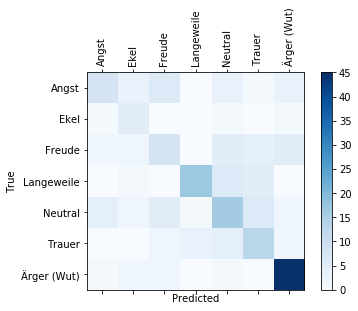

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusionmatrix(clf, y_test, y_pred, labels, cmap=plt.cm.Blues, title=''):
    """Utility to plot confusion matrix from Classifier
    clf - sklearn trained classifier
    y_test - test data. They are preprocessed, e.g. run through a label encoder
    y_pred - they come from the model
    labels - label names(len N Classes)
    cmap - color map)
    """

    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels, rotation=90)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

labels = [emotion_codes[x] for x in label_encoder.classes_]
plot_confusionmatrix(svm_clf, y_test_enc, y_pred, labels, cmap=plt.cm.Blues)